In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import gridspec
import scipy.stats as sts
from statsmodels.stats.weightstats import ztest
from scipy.stats import chisquare

In [21]:
df = pd.read_csv('https://raw.githubusercontent.com/tisheedesh/Project/main/Data/data_edaed.csv').drop('Unnamed: 0', axis=1)
df.head()

,Артикул,Для кого,Примерный вес,Тип металла,Проба,Покрытие,Тип вставки,Форма вставки,Количество,Цвет,Вес,Ширина кольца,Ширина,Высота,Номер страницы,Цена со скидкой,Цена без скидки
0,1011493,Для женщин,1.35,Белое золото,585.0,Родирование,Бриллиант (природный),Круг,1.0,Бесцветный,0.030,2.460293,7.272492,3.373794,1,35100,77990
1,1012584-3,Для женщин,0.90,Белое золото,585.0,Родирование,Бриллиант (природный),Круг,23.0,Бесцветный,0.069,2.000000,2.000000,1.000000,1,7990,7990
2,1011545-3,Для женщин,1.31,Белое золото,585.0,Родирование,Бриллиант (природный),Круг,57.0,Бесцветный,0.165,2.460293,7.272492,3.373794,1,56250,124990
3,019243,Для женщин,0.99,Красное золото,585.0,Неизвестно,Фианит,Круг,1.0,Бесцветный,0.846,2.000000,5.000000,4.000000,1,6990,6990
4,019263,Для женщин,0.97,Красное золото,585.0,Родирование,Фианит,Круг,5.0,Бесцветный,1.004,1.000000,3.000000,3.000000,1,6490,6490


### **Создание нового признака**
___
При парсинге мы подумали и решили добавить к каждому кольцу номер страницы, на которой это кольцо находилось, чтобы в дальнейшем что-нибудь прикольное придумать (так как кольца сортировались по популярности).

И к нам пришла идея разбить данный признак на 5 групп по популярности, чтобы учитывать популярность при построении линейной регрессии, а также попробовать предсказать популярность кольца (то есть этот показатель может выступать как в качестве независимой переменной, так и в качестве целевой переменной).

Получились группы: `Бестселлеры`, `Популярные`, `Средние`, `Непопулярные`, `Отвергнутые` (в каждом примерно одинаковое кол-во колец).

In [22]:
df['Популярность'] = 0
df.loc[df['Номер страницы'] < 146 // 5, 'Популярность'] = 'Бестселлеры'
df.loc[(df['Номер страницы'] >= 146 // 5) & (df['Номер страницы'] < 146 // 5 * 2), 'Популярность'] = 'Популярные'
df.loc[(df['Номер страницы'] >= 146 // 5 * 2) & (df['Номер страницы'] < 146 // 5 * 3), 'Популярность'] = 'Средние'
df.loc[(df['Номер страницы'] >= 146 // 5 * 3) & (df['Номер страницы'] < 146 // 5 * 4), 'Популярность'] = 'Непопулярные'
df.loc[df['Номер страницы'] >= 146 // 5 * 4, 'Популярность'] = 'Отвергнутые'

In [23]:
df['Популярность'].value_counts()

Популярность
Бестселлеры     895
Средние         882
Популярные      851
Отвергнутые     851
Непопулярные    786
Name: count, dtype: int64

### **Гипотезы + визуализация**

В процессе EDA и просто логического мышления мы выдвинули 6 гипотез.

#### **Первая гипотеза**
___
\
Мы предпологаем, что в среднем вес кольца у мужчин выше, чем у женщин.

**H0:** В среднем кольца для мужчин и для женщин не различаются по весу.

**H1:** Кольца для мужчин весят больше, чем для женщин.

Проверим данную гипотезу с помощью z-теста с уровнем значимости 0.05.

*Мы можем использовать z-тест, так как выполняются предпосылки (далее в следующих гипотезах до 5 включительно мы используем эти же предпосылки):*
1. *Непрерывная переменная*
2. *Выборки независимы (наблюдения в каждой подгруппе различны)*
3. *В соответствии с ЦПТ, так как у нас большое количество наблюдений (более 30), распределения стремятся к нормальному*

In [24]:
# больше количество наблюдений
df['Для кого'].value_counts()

Для кого
Для женщин                           3897
Для женщин, Для мужчин, Унисекс       219
Для мужчин                            121
Для детей                              15
Неизвестно                              7
Для женщин, Для мужчин, Для детей       6
Name: count, dtype: int64

In [25]:
women = df.loc[df['Для кого'] == 'Для женщин', 'Примерный вес']
men = df.loc[df['Для кого'] == 'Для мужчин', 'Примерный вес']
print(f'p-value = {ztest(women, men, alternative="smaller")[1]}')

p-value = 2.2377674907735932e-184


Полученное значение p-value сильно меньше 0.05, поэтому нулевая гипотеза **отвергается**, и с уверенностью 95% можно говорить о том, что кольца для мужчин весят больше, чем кольца для женщин.

Это то, о чем мы говорили в предыдущем разделе (EDA). Причиной такого распределения могут быть предпочтения мужчин, размеры кольца (возможно дело в ширине, толщине, так как обычно у мужчин руки больше).



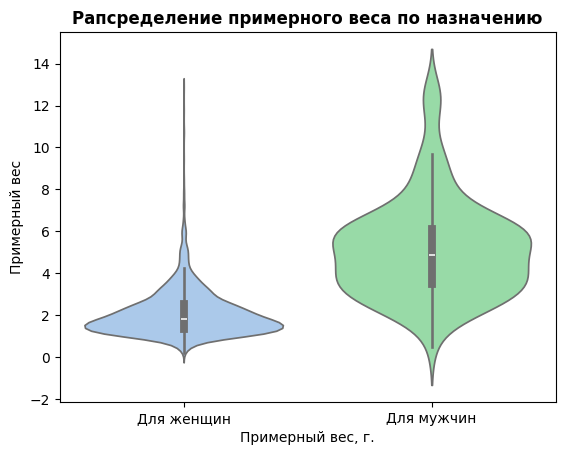

In [26]:
women_men = (df['Для кого'] == 'Для женщин') | (df['Для кого'] == 'Для мужчин')
sns.violinplot(x=df.loc[women_men, 'Для кого'], y=df.loc[women_men, 'Примерный вес'], hue=df['Для кого'], palette='pastel')
plt.legend().remove()
plt.title('Рапсределение примерного веса по назначению', fontweight='heavy')
plt.xlabel('Примерный вес, г.')
plt.show()

#### **Вторая гипотеза**
___
В нашем представлении белое золото обычно дороже жёлтого. Этого не было особо заметно на графиках, представленных в EDA, но возможно дело в камнях. Возьмем все кольца без вставок, чтобы наличие камней не влияло на цену.

Также используем z-тест при тех же предпосылках, что и в предыдущей гипотезе, с уровнем значимости 0.05

**H0:** Белое и желтое золото в среднем стоят одинаково

**H1:** Белое золото дороже желтого


In [27]:
# больше количество наблюдений
df.loc[df['Тип вставки'] == 'Без вставок', 'Тип металла'].value_counts()

Тип металла
Красное золото            368
Родированное серебро      273
Жёлтое золото              94
Чернёное серебро           69
Золочёное серебро          52
Белое золото               47
Комбинированное золото     29
Сталь                      25
Серебро                     6
Name: count, dtype: int64

In [28]:
white = df.loc[(df['Тип металла'] == 'Белое золото') & (df['Тип вставки'] == 'Без вставок'), 'Цена со скидкой']
yellow = df.loc[(df['Тип металла'] == 'Жёлтое золото') & (df['Тип вставки'] == 'Без вставок'), 'Цена со скидкой']
print(f'p-value = {ztest(white, yellow, alternative="larger")[1]}')

p-value = 0.2299290787071928


Получили p-value выше 0.05, значит, нулевая гипотеза **не отвергается**: кольца из белого золота в среднем стоят как кольца из желтого золота. Ну чтож, возможно, попались такие наблюдения, или наше представление о мире ювелирки неправильное.

#### **Третья гипотеза**
___
Гипотеза похожа на предыдущую: кольца из красного золота дешевле колец из желтого золота. Опять же, этого не было заметно в EDA, но может хоть тут повезет и наши предположения будут верны.

Все предпосылки сохраняются, используем z-тест с уровнем значимости 0.05.

**H0:** Кольца из красного и жёлтого золота стоят одинаково.

**H1:** Кольца из красного золота дешевле, чем из желтого.

In [29]:
red = df.loc[(df['Тип металла'] == 'Красное золото') & (df['Тип вставки'] == 'Без вставок'), 'Цена со скидкой']
yellow = df.loc[(df['Тип металла'] == 'Жёлтое золото') & (df['Тип вставки'] == 'Без вставок'), 'Цена со скидкой']
print(f'p-value = {ztest(yellow, red, alternative="larger")[1]}')

p-value = 0.9438627646351837


Гипотеза **не отвергается**, причем с высоким p-value. Изделия из красного и желтого золота в среднем похожи по цене.

Наше предположение с высокой вероятностью неверно.

По графику тоже видно, что кольца из разного типа золота стоят примерно одинаково. Различия в цвете золота обусловлены добавлением других металлов в сплав, которые, возможно, не сильно влияют на цену изделия, особенно если во всех изделиях одинаковое процентное содержание золота.

In [35]:
gold = (((df['Тип металла'] == 'Красное золото') |
        (df['Тип металла'] == 'Жёлтое золото') |
        (df['Тип металла'] == 'Белое золото')) &
        (df['Тип вставки'] == 'Без вставок'))

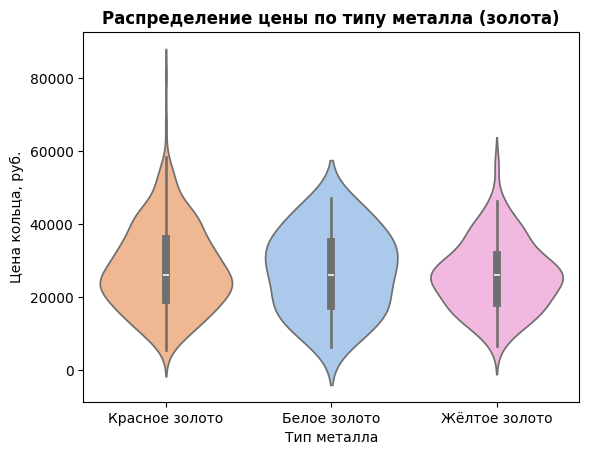

In [48]:
sns.violinplot(x=df.loc[gold, 'Тип металла'], y=df.loc[gold, 'Цена со скидкой'], hue=df['Тип металла'], palette='pastel')
plt.legend().remove()
plt.title('Распределение цены по типу металла (золота)', fontweight='heavy')
plt.ylabel('Цена кольца, руб.')
plt.show()

#### **Четвертая гипотеза**
___
Теперь посмотрим на серебро: черненое и родированное. На графике в EDA выглядит все так, как будто черненое стоит дороже родированного, проверим :) Также очистим кольца от тех, что со вставками.

Все предпосылки выполняются, проводим z-test с уровнем значимости 0.05.

**H0:** Кольца из родированного и черненого серебра стоят одинаково

**H1:** Кольца из черненого серебра стоят дороже, чем из черненого


In [37]:
# больше количество наблюдений
df.loc[df['Тип вставки'] == 'Без вставок', 'Тип металла'].value_counts()

Тип металла
Красное золото            368
Родированное серебро      273
Жёлтое золото              94
Чернёное серебро           69
Золочёное серебро          52
Белое золото               47
Комбинированное золото     29
Сталь                      25
Серебро                     6
Name: count, dtype: int64

In [39]:
chern = df.loc[(df['Тип металла'] == 'Чернёное серебро') & (df['Тип вставки'] == 'Без вставок'), 'Цена со скидкой']
rod = df.loc[(df['Тип металла'] == 'Родированное серебро') & (df['Тип вставки'] == 'Без вставок'), 'Цена со скидкой']
print(f'p-value = {ztest(chern, rod, alternative="larger")[1]}')

p-value = 5.037784202875739e-16


p-value ниже 0.05: гипотеза отвергается! И правда, можно говорить о том, что кольца из черненого серебра в среднем стоит дороже родированного.

#### **Пятая гипотеза**
___
Теперь проверим золоченое и родированное серебро. Проводим z-test с уровнем значимости 0.05.

**H0:** Кольца из родированного и золочёного серебра стоят одинаково.

**H1:** Кольца из родированного серебра дороже, чем из золоченого.


In [42]:
zoloch = df.loc[(df['Тип металла'] == 'Золочёное серебро') & (df['Тип вставки'] == 'Без вставок'), 'Цена со скидкой']
rod = df.loc[(df['Тип металла'] == 'Родированное серебро') & (df['Тип вставки'] == 'Без вставок'), 'Цена со скидкой']
print(f'p-value = {ztest(rod, zoloch, alternative="larger")[1]}')

p-value = 0.6090050312000163


Нулевая гипотеза **не отвергается**, так как p-value выше 0.05.

Получается, что черненое серебро дороже остальных (это видно и из графика ниже).

Черненое серебро часто требует кропотливой работы (так как часто они обрабатываются вручную, вырисовываются узоры и тд), из-за чего в том числе они могут быть популярны среди покупателей. Поэтому стоимость черненого серебра выше других видов.


In [43]:
silver = (((df['Тип металла'] == 'Родированное серебро') |
        (df['Тип металла'] == 'Золочёное серебро') |
        (df['Тип металла'] == 'Чернёное серебро')) &
        (df['Тип вставки'] == 'Без вставок'))

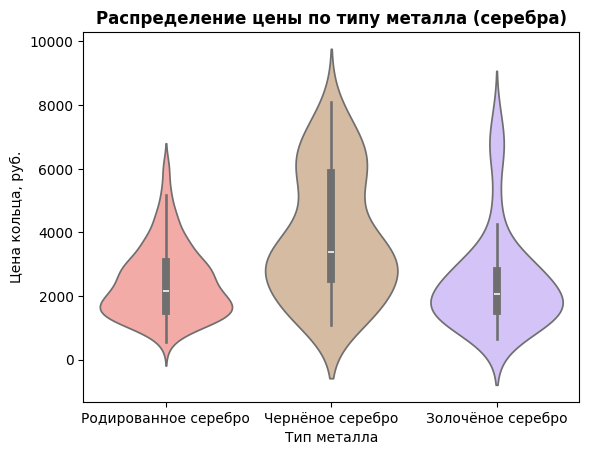

In [49]:
sns.violinplot(x=df.loc[silver, 'Тип металла'], y=df.loc[silver, 'Цена со скидкой'], hue=df['Тип металла'], palette='pastel')
plt.legend().remove()
plt.title('Распределение цены по типу металла (серебра)', fontweight='heavy')
plt.ylabel('Цена кольца, руб.')
plt.show()

#### **Шестая гипотеза**
___
В процессе подготовки и анализа данных, мы заметили, что на первых страницах (отсортированных по популярности) много колец с бриллиантами. Мы решили проверить, зависит ли популярность колец от наличия бриллиантов, или же в принципе бриллианты на всех страницах составляют подавляющее большинство среди вставок.

Проверям с помощью хи-квадрат критерия согласия с уровнем значимости 0.05. Посмотрим на зависимость между новым созданным признаком (популярность) и частотой бриллианта.

**H0:** Бриллианты встречаются с одинаковой частотой во всех категориях популярности

**H0:** Бриллианты встречаются с разной частотой в разных категориях популярности

In [62]:
brilliant = (df['Тип вставки'] == 'Бриллиант (природный)').sum()
f_exp = brilliant / 5 * np.ones(5)
f_obs = df.loc[df['Тип вставки'] == 'Бриллиант (природный)', 'Популярность'].value_counts().values
print(f'p-value = {chisquare(f_obs, f_exp).pvalue}')

p-value = 7.066166211919808e-13


Значение p-value ниже 0.05: гипотеза **отвергается**. То есть бриллианты неравномерно распределены по категориям популярности, и, может быть встречаются чаще на первых страницах.

Но если посмотреть на график ниже, похоже на то, что чаще бриллианты встречаются в `Бестселлерах` и в `Отвергнутых`, интересно...

(мы проверили лишь различия в частотах для разных категорий, и с высокой уверенностью можем говорить лишь об этом, остальное - додумки).

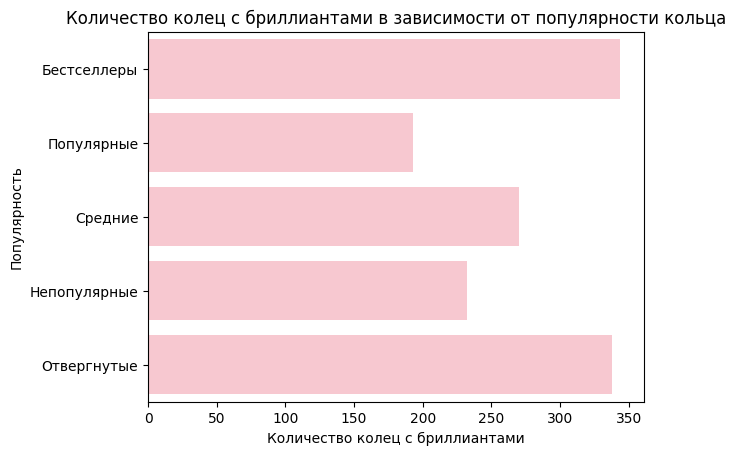

In [76]:
sns.countplot(df.loc[df['Тип вставки'] == 'Бриллиант (природный)', 'Популярность'], color='pink')
plt.title('Количество колец с бриллиантами в зависимости от популярности кольца')
plt.xlabel('Количество колец с бриллиантами');